In [50]:
import statsmodels.api as sm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [16]:
wti_gas_df = pd.read_csv('./data/wti_gas.csv').set_index('date')
wti_gas_df.index = pd.to_datetime(wti_gas_df.index) 
wti_gas_df

wti_gas_paper_df = wti_gas_df['1995-01': '2003-04']

In [17]:
df_spread = pd.read_csv('./data/tar_residual_gas_wti.csv').set_index('date')
df_spread.index = pd.to_datetime(df_spread.index) 
df_spread.columns = ['tar_spread_resid']

In [18]:
working_df = pd.concat([wti_gas_paper_df, df_spread], axis=1)
working_df.dropna(inplace=True)

In [32]:

spread_series = working_df['tar_spread_resid']
spread_std = spread_series.std()


# Threshold Filter (based on Standard Deviation)

In [33]:

def get_events_by_std_filter(spread: pd.Series, 
                                threshold: float) -> pd.DataFrame:
    
    frame = spread.copy().to_frame()
    
    buy_signal = frame.index.isin( spread[spread > threshold].index )
    sell_signal = frame.index.isin( spread[spread < -threshold].index )
    
    frame['side'] = 0
    frame.loc[buy_signal, 'side'] = 1 
    frame.loc[sell_signal, 'side'] = -1 
    frame['side'] = frame['side'].shift(1)
    
    return frame


In [34]:
std_events = get_events_by_stddev_filter(spread_series, spread_std)
std_events['side'].value_counts()

 0.0    1573
 1.0     324
-1.0     185
Name: side, dtype: int64

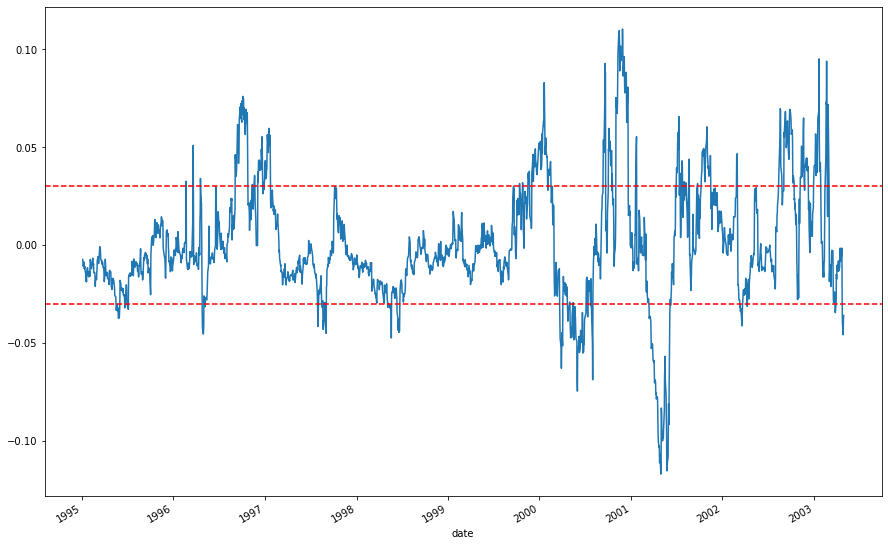

In [35]:
spread_series.plot(figsize=(15,10))

plt.axhline(y=spread_std, color='r', linestyle='--')
plt.axhline(y=-spread_std, color='r', linestyle='--')

# Asymmetric Threshold Filter

In [37]:

def get_events_by_asym_filter(spread: pd.Series,
                              threshold: float, 
                              p_1: float, p_2: float) -> pd.DataFrame:
    
    frame = spread.copy().to_frame()
    
    buy_signal = frame.index.isin( spread[spread > abs(p_1)*threshold].index )
    sell_signal = frame.index.isin( spread[spread < -abs(p_2)*threshold].index )
    
    frame['side'] = 0
    frame.loc[buy_signal, 'side'] = 1 
    frame.loc[sell_signal, 'side'] = -1 
    frame['side'] = frame['side'].shift(1)
    
    return frame

In [38]:
p_1 = -0.012957
p_2 = -0.038508

asym_events = get_events_by_asym_filter(spread_series, spread_std, p_1, p_2)
asym_events['side'].value_counts()

-1.0    1232
 1.0     795
 0.0      55
Name: side, dtype: int64

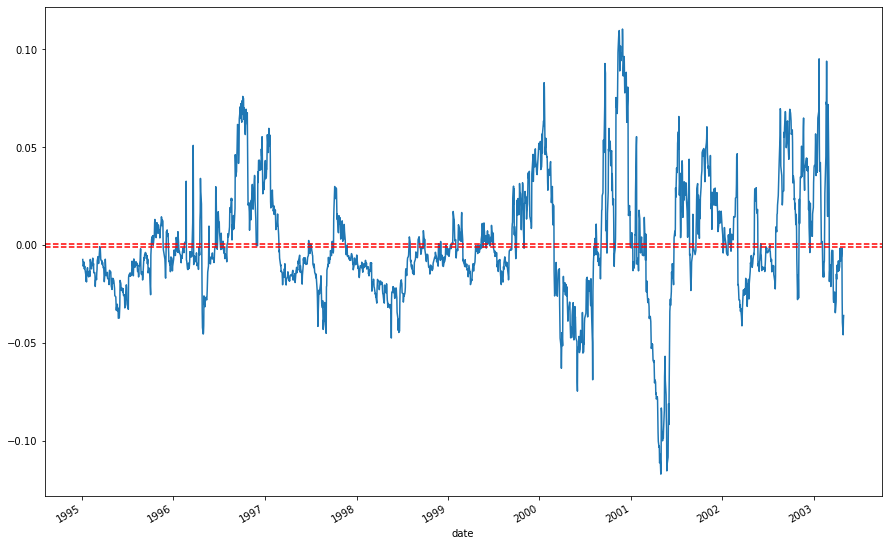

In [39]:
spread_series.plot(figsize=(15,10))

plt.axhline(y=abs(p_1)*spread_std, color='r', linestyle='--')
plt.axhline(y=-abs(p_2)*spread_std, color='r', linestyle='--')

# Correlation Filter (based on Dunis et al.)

In [196]:
from sklearn.preprocessing import MinMaxScaler
import mlfinlab as ml


def plot_corr(two_legged_df: pd.Series, spread: pd.Series, lookback: int = 30, 
                  buy_threshold: int = 0.2, sell_threshold: int = 0.9):
    
    corr_series = get_rolling_correlation(two_legged_df, lookback, scale=True)
    
    corr_events = get_events_by_corr_filter(two_legged_df, lookback=lookback, 
                                            buy_threshold=buy_threshold, 
                                            sell_threshold=sell_threshold)['side']
#     scaler = MinMaxScaler()
#     daily_vol = ml.util.get_daily_vol(close=spread, lookback=lookback)
#     scaled_vol = scaler.fit_transform(daily_vol.values.reshape(-1, 1))
#     vol_series = pd.Series(data=scaled_vol.reshape(1, -1)[0], index=daily_vol.index) 
    

    plt.figure(figsize=(15,10))
    plt.subplot(311)
    plt.plot(corr_series)
    plt.axhline(y=buy_threshold, color='g', linestyle='--')
    plt.axhline(y=sell_threshold, color='r', linestyle='--')
    
    plt.subplot(312)
    plt.plot(spread)
    for trade_evnt in spread[corr_events == 1].index:
        plt.axvline(trade_evnt, color="tab:green", alpha=0.2)
        
    plt.subplot(313)
    plt.plot(spread)
    for trade_evnt in spread[corr_events == -1].index:
        plt.axvline(trade_evnt, color="tab:red", alpha=0.2)
        
#     plt.plot_date(spread[corr_events == 1].index, spread[corr_events == 1], color='g', markersize=6)
#     plt.plot_date(spread[corr_events == 0].index, spread[corr_events == 0], color='b', markersize=4)
#     plt.plot_date(spread[corr_events == -1].index, spread[corr_events == -1], color='r', markersize=4)
#     plt.plot(vol_series)


def get_rolling_correlation(frame, lookback, scale=False):
    two_legged_df = frame.iloc[:, 0:2] 
    
    daily_corr = two_legged_df.rolling(lookback, min_periods=lookback).corr()
    daily_corr = daily_corr.iloc[:, 0].reset_index().dropna()
    
    final_corr = daily_corr[daily_corr['level_1'] == two_legged_df.columns[1]]
    final_corr.set_index('date', inplace=True)
    final_corr.drop(['level_1'], axis=1, inplace=True)
    final_corr.dropna(inplace=True)
    
    if scale:
        scaler = MinMaxScaler()
        scaled_corr = scaler.fit_transform(final_corr.iloc[:, 0].values.reshape(-1, 1))#.diff()
        corr_series = pd.Series(data=scaled_corr.reshape(1, -1)[0], index=final_corr.index) 
        return corr_series
    
    return final_corr
    

def get_events_by_corr_filter(frame: pd.DataFrame,
                              lookback=30,
                              buy_threshold=0.4,
                              sell_threshold=0.8):
    
    two_legged_df = frame.iloc[:, 0:2] 
    corr_series = get_rolling_correlation(two_legged_df, lookback, scale=True)
    
    buy_signal = frame.index.isin( corr_series[corr_series < buy_threshold].index )
    sell_signal = frame.index.isin( corr_series[corr_series > sell_threshold].index )
    
    frame['side'] = 0
    frame.loc[buy_signal, 'side'] = 1 
    frame.loc[sell_signal, 'side'] = -1 
    frame['side'] = frame['side'].shift(1)
    
    return frame



In [143]:
corr_events = get_events_by_corr_filter( working_df[['wti', 'gasoline']] )
corr_events['side'].value_counts()

-1.0    1403
 0.0     601
 1.0      78
Name: side, dtype: int64

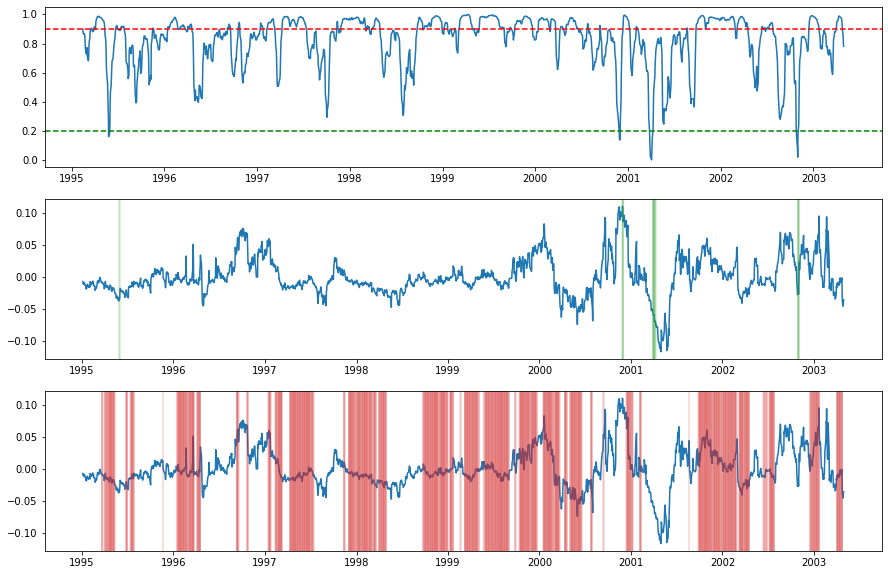

In [174]:
plot_corr_vol( working_df[['wti', 'gasoline']], spread_series )

# CUSUM Correlation Filter

In [194]:

def get_events_by_cusum_corr_filter(frame: pd.DataFrame,
                              lookback=30,
                              buy_threshold=0.1,
                              sell_threshold=0.9):
    
    two_legged_df = frame.iloc[:, 0:2] 
    
    corr_series = get_rolling_correlation(two_legged_df, lookback, scale=True)
    
    buy_event_dates = ml.filters.cusum_filter(corr_series, threshold=buy_threshold)
    buy_signal = frame.index.isin(buy_event_dates)
    
    sell_event_dates = ml.filters.cusum_filter(abs(corr_series-1), threshold=sell_threshold)
    sell_signal = frame.index.isin(sell_event_dates)

    frame['side'] = 0
    frame.loc[buy_signal, 'side'] = 1 
    frame.loc[sell_signal, 'side'] = -1 
    frame['side'] = frame['side'].shift(1)
    
    return frame

def plot_corr_cusum(two_legged_df: pd.Series, spread: pd.Series, lookback: int = 30, 
                    buy_threshold=0.1, sell_threshold=0.9):
    
    corr_series = get_rolling_correlation(two_legged_df, lookback, scale=True)
    corr_events = get_events_by_cusum_corr_filter(two_legged_df, lookback=lookback, 
                                                  buy_threshold=buy_threshold, 
                                                  sell_threshold=sell_threshold)['side']
    
#     scaler = MinMaxScaler()
#     daily_vol = ml.util.get_daily_vol(close=spread, lookback=lookback)
#     scaled_vol = scaler.fit_transform(daily_vol.values.reshape(-1, 1))
#     vol_series = pd.Series(data=scaled_vol.reshape(1, -1)[0], index=daily_vol.index) 
    

    plt.figure(figsize=(15,10))
    plt.subplot(411)
    plt.plot(corr_series)
    for trade_evnt in spread[corr_events == 1].index:
        plt.axvline(trade_evnt, color="tab:green", alpha=0.2)
    
    plt.subplot(412)
    plt.plot(spread)
    for trade_evnt in spread[corr_events == 1].index:
        plt.axvline(trade_evnt, color="tab:green", alpha=0.2)

    plt.subplot(413)
    plt.plot(corr_series)
    for trade_evnt in spread[corr_events == -1].index:
        plt.axvline(trade_evnt, color="tab:red", alpha=0.2)
        
    plt.subplot(414)
    plt.plot(spread)
    for trade_evnt in spread[corr_events == -1].index:
        plt.axvline(trade_evnt, color="tab:red", alpha=0.2)
        
#     plt.plot_date(spread[corr_events == 1].index, spread[corr_events == 1], color='g', markersize=6)
#     plt.plot_date(spread[corr_events == 0].index, spread[corr_events == 0], color='b', markersize=4)
#     plt.plot_date(spread[corr_events == -1].index, spread[corr_events == -1], color='r', markersize=4)
#     plt.plot(vol_series)



In [197]:
cusum_corr_events = get_events_by_cusum_corr_filter( working_df[['wti', 'gasoline']] )
cusum_corr_events['side'].value_counts()

 0.0    1642
 1.0     277
-1.0     163
Name: side, dtype: int64

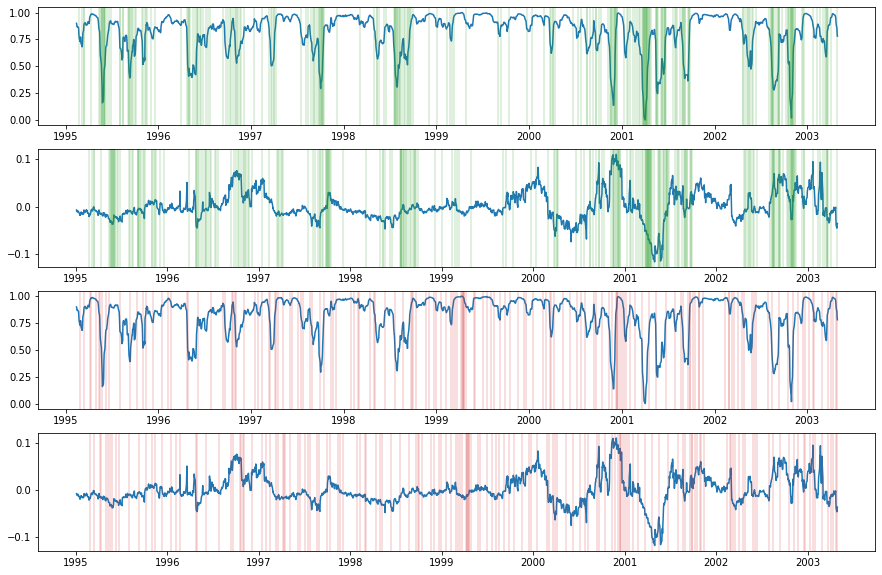

In [199]:
plot_corr_cusum(working_df[['wti', 'gasoline']], spread_series)